## Binary classification problem

### Dataset :

We study first a binary classification problem, performed by a neural network. Each input has two real features, and the output can be only 0 or 1. The training set contains 4000 examples, and the validation set, 1000.

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Display figures on jupyter notebook
%matplotlib inline

In [0]:
# Define a function to generate the dataset, in the form of two interlaced spirals
def spiral(phi):
    x = (phi+1)*torch.cos(phi)
    y = phi*torch.sin(phi)
    return torch.cat((x, y), dim=1)

def generate_data(num_data):
    angles = torch.empty((num_data, 1)).uniform_(0, 10)
    data = spiral(angles)
    # add some noise to the data
    data += torch.empty((num_data, 2)).normal_(0.0, 0.3)
    labels = torch.zeros((num_data,), dtype=torch.int)
    # flip half of the points to create two classes
    data[num_data//2:,:] *= -1
    labels[num_data//2:] = 1
    return data, labels

In [0]:
# Generate the training set with 4000 examples by function generate_data

X_train, y_train = generate_data(4000)
X_train.size()

torch.Size([4000, 2])

In [0]:
# Define the vis_data function to visualize the dataset
def vis_data(X, y):
    plt.figure(figsize=(5, 5))
    plt.plot(X[y==1, 0], X[y==1, 1], 'r+') #Examples are represented as red plusses for label 1
    plt.plot(X[y==0, 0], X[y==0, 1], 'b+') #Examples are represented as blue plusses for label 0 

We can now invoke the `vis_data` function on the dataset previously generated to see what it looks like:

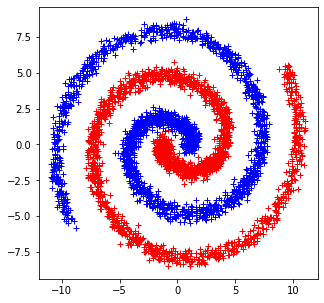

In [0]:
vis_data(X_train, y_train) # visualize training set

We use the `TensorDataset` wrapper from pytorch, so that the framework can easily understand our tensors as a proper dataset.

In [0]:
from torch.utils.data import TensorDataset, DataLoader
training_set = TensorDataset(X_train, y_train)

###  Training the model with a neural network

Here is a skeleton of a neural network with a single layer (thus: a linear classifier). This is the model you'll work on to improve it during this exercise.

Look at the code and run it to see the structure, then follow the questions below to iteratively improve the model.

In [0]:
import torch.nn as nn
import torch.nn.functional as F

At the first step, we define a neural network with just one layer. A useful tutorial for constructing model can be found [here](https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html#sphx-glr-beginner-blitz-neural-networks-tutorial-py).

In [0]:
# Basic network structure with a single layer
class Model(nn.Module):
    
    def __init__(self):
        super(Model, self).__init__()
        # A single linear layer
        # The model has 2 inputs (the coordinates of the point) and an output (the prediction)
        self.l1 = nn.Linear(2, 1)
        
    def forward(self, inputs):
        # We want the model to predict 0 for one class and 1 for the other class
        # A Sigmoid activation function seems appropriate
        outputs = torch.sigmoid(self.l1(inputs))
        return outputs

In [0]:
# Create the model: 
model = Model()

# Choose the hyperparameters for training: 
num_epochs = 10
batch_size = 10

# Training criterion. This one is a mean squared error (MSE) loss between the output
# of the network and the target label
criterion = nn.MSELoss()

# Use SGD optimizer with a learning rate of 0.01
# It is initialized on our model
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

#### Training the defined model
More information can be found [here](https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html#sphx-glr-beginner-blitz-neural-networks-tutorial-py).

In [0]:
# define a function for training
def train(num_epochs, batch_size, criterion, optimizer, model, dataset):
    train_error = []
    train_loader = DataLoader(dataset, batch_size, shuffle=True)
    model.train()
    for epoch in range(num_epochs):
        epoch_average_loss = 0.0
        for (X_batch, y_real) in train_loader:
            y_pre = model(X_batch).view(-1)
            loss = criterion(y_pre, y_real.float())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_average_loss += loss.item() * batch_size / len(dataset)
        train_error.append(epoch_average_loss)
        print('Epoch [{}/{}], Loss: {:.4f}'
                      .format(epoch+1, num_epochs, epoch_average_loss))
    return train_error

In [0]:
train_error = train(num_epochs, batch_size, criterion, optimizer, model, training_set)

Epoch [1/10], Loss: 0.2463
Epoch [2/10], Loss: 0.2403
Epoch [3/10], Loss: 0.2377
Epoch [4/10], Loss: 0.2370
Epoch [5/10], Loss: 0.2364
Epoch [6/10], Loss: 0.2362
Epoch [7/10], Loss: 0.2364
Epoch [8/10], Loss: 0.2360
Epoch [9/10], Loss: 0.2363
Epoch [10/10], Loss: 0.2362


Text(0.5, 1.0, 'Visualization of convergence')

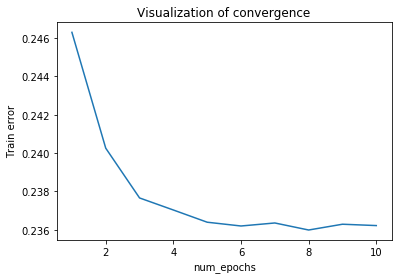

In [0]:
# plot the training error wrt. the number of epochs: 
plt.plot(range(1, num_epochs+1), train_error)
plt.xlabel("num_epochs")
plt.ylabel("Train error")
plt.title("Visualization of convergence")

#### Evaluate the model on the validation set

In [0]:
# Generate 1000 validation data:
X_val, y_val = generate_data(1000)

In [0]:
# predict labels for validation set
model.eval() # set the model to test mode
with torch.no_grad():
    y_pre = model(X_val).view(-1)

In [0]:
# Calculate the accuracy on validation set to evaluate the model by the function accuracy
def accuracy(y_real, y_pre):
    y_pre[y_pre<0.5] = 0
    y_pre[y_pre>=0.5] = 1

    acc = 1 - torch.sum(torch.abs(y_pre - y_real))/len(y_pre)
    print('Accuracy of the network on the 1000 validation data: {:.2f} %'.format(acc.item()*100))

In [0]:
accuracy(y_val, y_pre)

Accuracy of the network on the 1000 validation data: 60.70 %


In [0]:
# Compare the prediction with real labels

def compare_pred(X, y_real, y_pre):
    plt.figure(figsize=(10, 5))

    plt.subplot(121)
    plt.plot(X[y_real==1, 0], X[y_real==1, 1], 'r+') #Examples are represented as a red plusses for label 1
    plt.plot(X[y_real==0, 0], X[y_real==0, 1], 'b+') #Examples are represented as a blue plusses for label 0
    plt.title("real data")

    plt.subplot(122)
    plt.plot(X[y_pre==1, 0], X[y_pre==1, 1], 'r+')
    plt.plot(X[y_pre==0, 0], X[y_pre==0, 1], 'b+')
    plt.title("prediciton results")

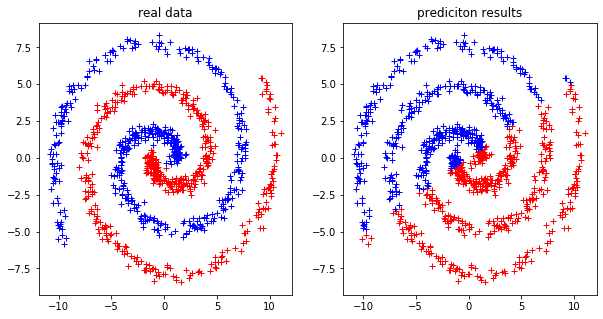

In [0]:
compare_pred(X_val, y_val, y_pre)

### Exercise 1: Impact of the architecture of the model

The class `Model` is the definition of your model. You can now modify it to try out different architectures and
see the impact of the following factors:

* Try to add more layers (1, 2, 3, more ?)
* Try to different activation functions ([sigmoid](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.sigmoid), [tanh](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.tanh), [relu](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.relu), etc.)
* Try to change the number of neurons for each layer (5, 10, 20, more ?)

In [0]:
# Other more complex models
class new_Model(nn.Module):
    
    def __init__(self, with_activation=True):
        super(new_Model, self).__init__()
        self.l1 = nn.Linear(2, 10)
        self.l2 = nn.Linear(10, 8)
        self.l3 = nn.Linear(8, 4)
        self.l4 = nn.Linear(4, 1)
        self.activate = with_activation
        self.net = nn.Sequential(self.l1, nn.Sigmoid(), self.l2, nn.Sigmoid(), self.l3, nn.Sigmoid(),
                                 self.l4)

    def forward(self, inputs):
        if self.activate:
          outputs = torch.sigmoid(self.net(inputs))
        else:
          outputs = self.net(inputs)
        return outputs

class new_Model2(nn.Module):
    
    def __init__(self, with_activation=True):
        super(new_Model2, self).__init__()
        self.l1 = nn.Linear(2, 10)
        self.l2 = nn.Linear(10, 1)
        self.activate = with_activation
        self.net = nn.Sequential(self.l1, nn.Sigmoid(), self.l2)

    def forward(self, inputs):
        if self.activate:
          outputs = torch.sigmoid(self.net(inputs))
        else:
          outputs = self.net(inputs)
        return outputs

class new_Model3(nn.Module):
    
    def __init__(self, with_activation=True):
        super(new_Model3, self).__init__()
        self.l1 = nn.Linear(2, 8)
        self.l2 = nn.Linear(8, 5)
        self.l3 = nn.Linear(5, 1)
        self.net = nn.Sequential(self.l1, nn.Sigmoid(), self.l2, nn.Sigmoid(), self.l3)
        self.activate = with_activation
        
    def forward(self, inputs):
        if self.activate:
          outputs = torch.tanh(self.net(inputs))
        else:
          outputs = self.net(inputs)
        return outputs


class new_Model4(nn.Module):
    
    def __init__(self, with_activation=True):
        super(new_Model4, self).__init__()
        self.l1 = nn.Linear(2, 8)
        self.l2 = nn.Linear(8, 5)
        self.l3 = nn.Linear(5, 1)
        self.net = nn.Sequential(self.l1, nn.ReLU(), self.l2, nn.ReLU(), self.l3)
        self.activate = with_activation
        
    def forward(self, inputs):
        if self.activate:
          outputs = torch.tanh(self.net(inputs))
        else:
          outputs = self.net(inputs)
        return outputs

Epoch [1/10], Loss: 0.2556
Epoch [2/10], Loss: 0.2510
Epoch [3/10], Loss: 0.2506
Epoch [4/10], Loss: 0.2505
Epoch [5/10], Loss: 0.2505
Epoch [6/10], Loss: 0.2505
Epoch [7/10], Loss: 0.2504
Epoch [8/10], Loss: 0.2504
Epoch [9/10], Loss: 0.2504
Epoch [10/10], Loss: 0.2504
Accuracy of the network on the 1000 validation data: 48.50 %
None
Epoch [1/10], Loss: 0.2477
Epoch [2/10], Loss: 0.2447
Epoch [3/10], Loss: 0.2428
Epoch [4/10], Loss: 0.2415
Epoch [5/10], Loss: 0.2407
Epoch [6/10], Loss: 0.2400
Epoch [7/10], Loss: 0.2394
Epoch [8/10], Loss: 0.2391
Epoch [9/10], Loss: 0.2389
Epoch [10/10], Loss: 0.2386
Accuracy of the network on the 1000 validation data: 60.20 %
None
Epoch [1/10], Loss: 0.2507
Epoch [2/10], Loss: 0.2495
Epoch [3/10], Loss: 0.2491
Epoch [4/10], Loss: 0.2486
Epoch [5/10], Loss: 0.2482
Epoch [6/10], Loss: 0.2471
Epoch [7/10], Loss: 0.2469
Epoch [8/10], Loss: 0.2465
Epoch [9/10], Loss: 0.2458
Epoch [10/10], Loss: 0.2452
Accuracy of the network on the 1000 validation data: 55

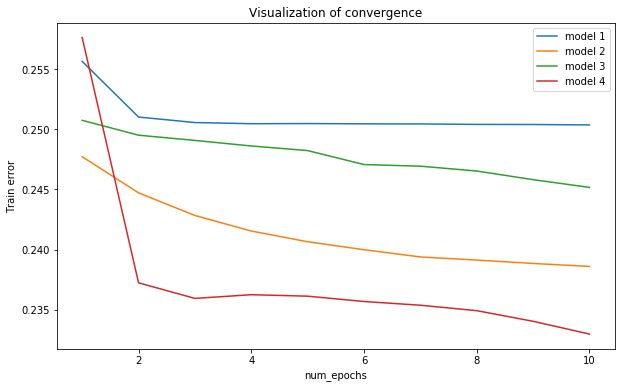

In [0]:
dico_models = {"model 1": new_Model(),
               "model 2": new_Model2(),
               "model 3": new_Model3(),
               "model 4": new_Model4()}
num_epochs = 10
batch_size = 10
criterion = nn.MSELoss()
plt.figure(figsize=(10, 6))
titles = []
for key in dico_models.keys():
  titles.append(key)
  model = dico_models[key]
  optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
  train_error = train(num_epochs, batch_size, criterion, optimizer, model, training_set)
  model.eval() # set the model to test mode
  plt.plot(range(1, num_epochs+1), train_error)
  with torch.no_grad():
    y_pre = model(X_val).view(-1)
    print(accuracy(y_val, y_pre))
plt.xlabel("num_epochs")
plt.ylabel("Train error")
plt.title("Visualization of convergence")
plt.legend(titles)
plt.show()

The fourth model seems to be the best, let's use it for the next questions...

### Exercise 2: Impact of the optimizer

Retrain the model by using different parameters of the optimizer, you can change its parameter in the cell initializing it, after the definition of your model.

* Use different batch size from 10 to 400
* Try different values of the learning rate (between 0.001 and 10), and see how these impact the trainig process. Do all network architectures react the same way to different learning rates?
* Change the duration of the training by increasing the number of epochs
* Try other optimizers, such as [Adam](https://pytorch.org/docs/stable/optim.html?highlight=adam#torch.optim.Adam) or [RMSprop](https://pytorch.org/docs/stable/optim.html?highlight=rmsprop#torch.optim.RMSprop)

**Note:** These changes may interact with your previous choices of architectures, and you may need to change them as well!

In [0]:
dico_models.keys()

dict_keys(['model 1', 'model 2', 'model 3', 'model 4'])

Epoch [1/10], Loss: 0.2496
Epoch [2/10], Loss: 0.2368
Epoch [3/10], Loss: 0.2352
Epoch [4/10], Loss: 0.2338
Epoch [5/10], Loss: 0.2326
Epoch [6/10], Loss: 0.2313
Epoch [7/10], Loss: 0.2303
Epoch [8/10], Loss: 0.2291
Epoch [9/10], Loss: 0.2283
Epoch [10/10], Loss: 0.2272
Accuracy of the network on the 1000 validation data: 61.10 %
None
Epoch [1/10], Loss: 0.2673
Epoch [2/10], Loss: 0.2441
Epoch [3/10], Loss: 0.2430
Epoch [4/10], Loss: 0.2420
Epoch [5/10], Loss: 0.2413
Epoch [6/10], Loss: 0.2402
Epoch [7/10], Loss: 0.2390
Epoch [8/10], Loss: 0.2380
Epoch [9/10], Loss: 0.2368
Epoch [10/10], Loss: 0.2359
Accuracy of the network on the 1000 validation data: 66.20 %
None
Epoch [1/10], Loss: 0.4367
Epoch [2/10], Loss: 0.2898
Epoch [3/10], Loss: 0.2668
Epoch [4/10], Loss: 0.2558
Epoch [5/10], Loss: 0.2492
Epoch [6/10], Loss: 0.2448
Epoch [7/10], Loss: 0.2416
Epoch [8/10], Loss: 0.2394
Epoch [9/10], Loss: 0.2377
Epoch [10/10], Loss: 0.2365
Accuracy of the network on the 1000 validation data: 59

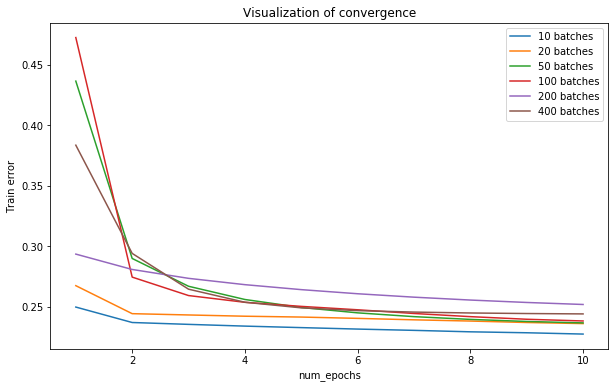

In [0]:
num_epochs = 10
batch_size = [10, 20, 50, 100, 200, 400]
criterion = nn.MSELoss()
plt.figure(figsize=(10, 6))
titles = []
for batch in batch_size:
  titles.append(str(batch) + ' batches')
  model = new_Model4()
  optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
  train_error = train(num_epochs, batch, criterion, optimizer, model, training_set)
  model.eval() # set the model to test mode
  plt.plot(range(1, num_epochs+1), train_error)
  with torch.no_grad():
    y_pre = model(X_val).view(-1)
    print(accuracy(y_val, y_pre))
plt.xlabel("num_epochs")
plt.ylabel("Train error")
plt.title("Visualization of convergence")
plt.legend(titles)
plt.show()

10 batches seems to be a good choice for this model...

Epoch [1/30], Loss: 0.4383
Epoch [2/30], Loss: 0.2606
Epoch [3/30], Loss: 0.2514
Epoch [4/30], Loss: 0.2464
Epoch [5/30], Loss: 0.2428
Epoch [6/30], Loss: 0.2401
Epoch [7/30], Loss: 0.2381
Epoch [8/30], Loss: 0.2366
Epoch [9/30], Loss: 0.2354
Epoch [10/30], Loss: 0.2344
Epoch [11/30], Loss: 0.2335
Epoch [12/30], Loss: 0.2327
Epoch [13/30], Loss: 0.2319
Epoch [14/30], Loss: 0.2313
Epoch [15/30], Loss: 0.2306
Epoch [16/30], Loss: 0.2301
Epoch [17/30], Loss: 0.2297
Epoch [18/30], Loss: 0.2293
Epoch [19/30], Loss: 0.2288
Epoch [20/30], Loss: 0.2285
Epoch [21/30], Loss: 0.2281
Epoch [22/30], Loss: 0.2277
Epoch [23/30], Loss: 0.2273
Epoch [24/30], Loss: 0.2270
Epoch [25/30], Loss: 0.2266
Epoch [26/30], Loss: 0.2263
Epoch [27/30], Loss: 0.2259
Epoch [28/30], Loss: 0.2256
Epoch [29/30], Loss: 0.2253
Epoch [30/30], Loss: 0.2249
Accuracy of the network on the 1000 validation data: 69.30 %
None
Epoch [1/30], Loss: 0.2948
Epoch [2/30], Loss: 0.2431
Epoch [3/30], Loss: 0.2368
Epoch [4/30], Loss: 0.

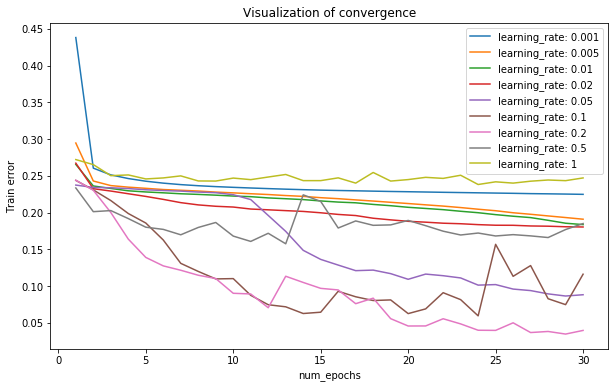

In [0]:
num_epochs = 30
batch_size = 10
criterion = nn.MSELoss()
plt.figure(figsize=(10, 6))
titles = []
lrs = [0.001, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1]
for lr in lrs:
  titles.append('learning_rate: ' + str(lr))
  model = new_Model4()
  optimizer = torch.optim.SGD(model.parameters(), lr=lr)
  train_error = train(num_epochs, batch_size, criterion, optimizer, model, training_set)
  model.eval() # set the model to test mode
  plt.plot(range(1, num_epochs+1), train_error)
  with torch.no_grad():
    y_pre = model(X_val).view(-1)
    print(accuracy(y_val, y_pre))
plt.xlabel("num_epochs")
plt.ylabel("Train error")
plt.title("Visualization of convergence")
plt.legend(titles)
plt.show()

learning rate around 0.2 seems good

Epoch [1/20], Loss: 0.2175
Epoch [2/20], Loss: 0.1577
Epoch [3/20], Loss: 0.1077
Epoch [4/20], Loss: 0.0882
Epoch [5/20], Loss: 0.0668
Epoch [6/20], Loss: 0.0577
Epoch [7/20], Loss: 0.0511
Epoch [8/20], Loss: 0.0443
Epoch [9/20], Loss: 0.0449
Epoch [10/20], Loss: 0.0415
Epoch [11/20], Loss: 0.0420
Epoch [12/20], Loss: 0.0410
Epoch [13/20], Loss: 0.0390
Epoch [14/20], Loss: 0.0374
Epoch [15/20], Loss: 0.0413
Epoch [16/20], Loss: 0.0337
Epoch [17/20], Loss: 0.0307
Epoch [18/20], Loss: 0.0334
Epoch [19/20], Loss: 0.0278
Epoch [20/20], Loss: 0.0341
Accuracy of the network on the 1000 validation data: 97.80 %
None


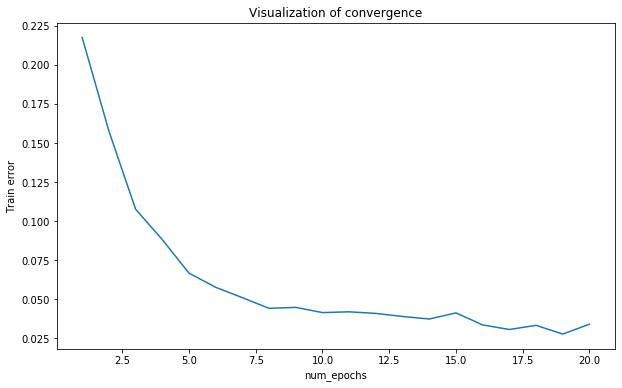

In [0]:
num_epochs = 20
batch_size = 10
criterion = nn.MSELoss()
plt.figure(figsize=(10, 6))
model = new_Model4()
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.01)
train_error = train(num_epochs, batch_size, criterion, optimizer, model, training_set)
model.eval() # set the model to test mode
plt.plot(range(1, num_epochs+1), train_error)
with torch.no_grad():
  y_pre = model(X_val).view(-1)
  print(accuracy(y_val, y_pre))
plt.xlabel("num_epochs")
plt.ylabel("Train error")
plt.title("Visualization of convergence")
plt.show()

### Exercise 3: Impact of the loss function

The current model uses a mean square error (MSE) loss. While this loss can be used in this case, it is now rarely used for classification, and instead a Binary Cross Entropy (BCE) is used. It consists in interpreting the output of the network as the probability $p(y | x)$ of the point $x$ to belong to the class $y$, and in maximizing the probability to be correct for all samples $x$, that is, in maximizing $\displaystyle \prod_{(x,y) \in Dataset} p(y|x)$. Applying $-\log$ to this quantity, we obtain the following criterion to minimize:

$$ \sum_{(x,y) \in Dataset} - \log p(y | x) $$

This is implemented as such by the [BCELoss](https://pytorch.org/docs/stable/nn.html?highlight=bce#torch.nn.BCELoss) of pytorch. Note that this criterion requires its input to be a probability, i.e. in $[0,1]$, which requires the use of an appropriate activation function beforehand, e.g., a sigmoid.

It turns out that, for numerical stability reasons, it is better to incorporate this sigmoid and the BCELoss into a single function; this is done by the [BCEWithLogitsLoss](https://pytorch.org/docs/stable/nn.html?highlight=bcewithlogit#torch.nn.BCEWithLogitsLoss). Try to replace the MSE by this one and see how this changes the behavior in the network. This can also interact with the changes of the two previous exercices.

**Note:** As a consequence, when using the BCEWithLogitsLoss, the last layer of your network should not be followed by an activation function, as BCEWithLogitsLoss already adds a sigmoid.

Epoch [1/60], Loss: 0.6681
Epoch [2/60], Loss: 0.6570
Epoch [3/60], Loss: 0.6491
Epoch [4/60], Loss: 0.6403
Epoch [5/60], Loss: 0.6199
Epoch [6/60], Loss: 0.5637
Epoch [7/60], Loss: 0.5154
Epoch [8/60], Loss: 0.4645
Epoch [9/60], Loss: 0.3904
Epoch [10/60], Loss: 0.3279
Epoch [11/60], Loss: 0.2657
Epoch [12/60], Loss: 0.2107
Epoch [13/60], Loss: 0.1692
Epoch [14/60], Loss: 0.1371
Epoch [15/60], Loss: 0.1029
Epoch [16/60], Loss: 0.0897
Epoch [17/60], Loss: 0.0662
Epoch [18/60], Loss: 0.0727
Epoch [19/60], Loss: 0.0517
Epoch [20/60], Loss: 0.0509
Epoch [21/60], Loss: 0.0574
Epoch [22/60], Loss: 0.0466
Epoch [23/60], Loss: 0.0175
Epoch [24/60], Loss: 0.1039
Epoch [25/60], Loss: 0.0461
Epoch [26/60], Loss: 0.0310
Epoch [27/60], Loss: 0.0117
Epoch [28/60], Loss: 0.0098
Epoch [29/60], Loss: 0.0096
Epoch [30/60], Loss: 0.1306
Epoch [31/60], Loss: 0.2594
Epoch [32/60], Loss: 0.1646
Epoch [33/60], Loss: 0.1574
Epoch [34/60], Loss: 0.0994
Epoch [35/60], Loss: 0.1302
Epoch [36/60], Loss: 0.1803
E

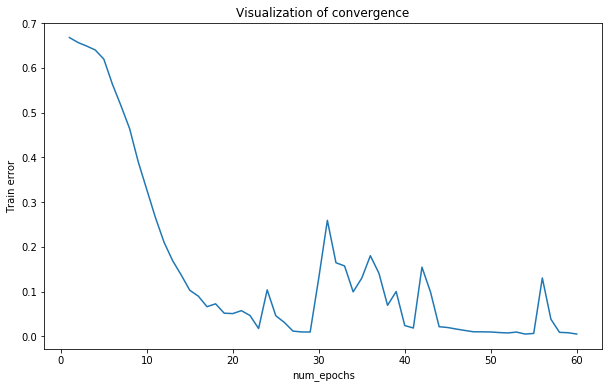

In [0]:
dico_models = {"model 1": new_Model(False),
               "model 2": new_Model2(False),
               "model 3": new_Model3(False),
               "model 4": new_Model4(False)}
num_epochs =60
batch_size = 10
criterion = nn.BCEWithLogitsLoss()
plt.figure(figsize=(10, 6))

model = new_Model4(False)
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)
train_error = train(num_epochs, batch_size, criterion, optimizer, model, training_set)
model.eval() # set the model to test mode
plt.plot(range(1, num_epochs+1), train_error)
with torch.no_grad():
  y_pre = model(X_val).view(-1)
  print(accuracy(y_val, y_pre))
plt.xlabel("num_epochs")
plt.ylabel("Train error")
plt.title("Visualization of convergence")
plt.show()

### Exercise 4: Prediction on test set

Once you have a model that seems satisfying on the validation dataset, you SHOULD evaluate it on a test dataset that has never been used before, to obtain a final accuracy value.

In [0]:
# Here is a test dataset. Use it similarly to the validaiton dataset above
# to compute the final performance of your model
X_test, y_test = generate_data(1000)

In [0]:
num_epochs = 60
batch_size = 10
criterion = nn.BCEWithLogitsLoss()
model = new_Model4(False)
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)
train_error = train(num_epochs, batch_size, criterion, optimizer, model, training_set)

Epoch [1/60], Loss: 0.6742
Epoch [2/60], Loss: 0.6593
Epoch [3/60], Loss: 0.6551
Epoch [4/60], Loss: 0.6503
Epoch [5/60], Loss: 0.6445
Epoch [6/60], Loss: 0.6335
Epoch [7/60], Loss: 0.6127
Epoch [8/60], Loss: 0.5956
Epoch [9/60], Loss: 0.5755
Epoch [10/60], Loss: 0.5545
Epoch [11/60], Loss: 0.5494
Epoch [12/60], Loss: 0.5372
Epoch [13/60], Loss: 0.5213
Epoch [14/60], Loss: 0.5190
Epoch [15/60], Loss: 0.5104
Epoch [16/60], Loss: 0.4798
Epoch [17/60], Loss: 0.4613
Epoch [18/60], Loss: 0.4309
Epoch [19/60], Loss: 0.4295
Epoch [20/60], Loss: 0.4171
Epoch [21/60], Loss: 0.3953
Epoch [22/60], Loss: 0.3838
Epoch [23/60], Loss: 0.3799
Epoch [24/60], Loss: 0.3562
Epoch [25/60], Loss: 0.3635
Epoch [26/60], Loss: 0.3384
Epoch [27/60], Loss: 0.2757
Epoch [28/60], Loss: 0.2532
Epoch [29/60], Loss: 0.1506
Epoch [30/60], Loss: 0.1302
Epoch [31/60], Loss: 0.1529
Epoch [32/60], Loss: 0.1355
Epoch [33/60], Loss: 0.1060
Epoch [34/60], Loss: 0.0692
Epoch [35/60], Loss: 0.0545
Epoch [36/60], Loss: 0.0359
E

In [0]:
model.eval()
with torch.no_grad():
  y_pre = model(X_test).view(-1)
  print(accuracy(y_test, y_pre))

Accuracy of the network on the 1000 validation data: 99.80 %
None


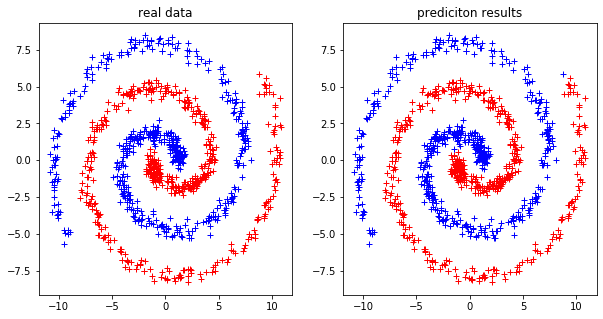

In [0]:
compare_pred(X_test, y_test, y_pre)